# Testing skill of single CMIP6 climate model 
Using 10 years of historical simulation (2005-2014) and 10 years of SSP245 (2015-2024) monthly data. Comparing to ERA5 montly data.

In [1]:
import xarray as xr
import pandas as pd
import xesmf as xe
import xskillscore as xs

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
hist_df = pd.read_csv('gcs_cmip6_historical_paths.csv').drop(columns=['Unnamed: 0'])
ssp_df = pd.read_csv('gcs_cmip6_ssp245_paths.csv')

# pick an org, model, and ensemble 
test_org = 'IPSL'
test_model = 'IPSL-CM6A-LR'
test_ensemble = 'r1i1p1f1'
test_hist_file_path_df = hist_df[(hist_df['Org'] == test_org) & (hist_df['Model'] == test_model) & (hist_df['ensemble'] == test_ensemble)]
test_ssp_file_path_df = ssp_df[(ssp_df['Org'] == test_org)& (ssp_df['Model'] == test_model) & (ssp_df['ensemble'] == test_ensemble)]

test_hist_file_path_df['path'] = test_hist_file_path_df[test_hist_file_path_df.columns].agg('/'.join, axis=1)
test_ssp_file_path_df['path'] = test_ssp_file_path_df[test_ssp_file_path_df.columns].agg('/'.join, axis=1)

/var/folders/ys/qmftlyyx3dj63021dv4205g80000gn/T/ipykernel_54807/3451432622.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_hist_file_path_df['path'] = test_hist_file_path_df[test_hist_file_path_df.columns].agg('/'.join, axis=1)
/var/folders/ys/qmftlyyx3dj63021dv4205g80000gn/T/ipykernel_54807/3451432622.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ssp_file_path_df['path'] = test_ssp_file_path_df[test_ssp_file_path_df.columns].agg('/'.join, axis=1)


In [3]:
test_var = 'tas'
hist_ds = xr.open_zarr(
    f"gs://cmip6/{test_hist_file_path_df[test_hist_file_path_df['var']==test_var].iloc[0]['path']}",
    chunks={}, 
    consolidated=True,
)
hist_ds = hist_ds.sel(time=slice('2005-01-01','2014-12-31'))
hist_ds['time'] = pd.to_datetime(hist_ds['time'].dt.strftime('%Y-%m-01')) # setting to the first of the month to match with era5
ssp_ds = xr.open_zarr(
    f"gs://cmip6/{test_ssp_file_path_df[test_ssp_file_path_df['var']==test_var].iloc[0]['path']}",
    chunks={}, 
    consolidated=True,
)
ssp_ds = ssp_ds.sel(time=slice('2015-01-01','2024-12-31'))
ssp_ds['time'] = pd.to_datetime(ssp_ds['time'].dt.strftime('%Y-%m-01')) # setting to the first of the month to match with era5

In [4]:
# era5 data downloaded manually from: https://cds.climate.copernicus.eu/requests?tab=all

# era5_ds = xr.open_dataset('era5_monthly.grib', engine="cfgrib")
# era5_tas_ds = era5_ds['t2m'].to_dataset(name='tas').rename({'latitude':'lat','longitude':'lon'})
# era5_tas_ds.chunk({'time':120,'lat':-1,'lon':-1}).to_zarr('era5_monthly_tas.zarr')
era5_tas_ds = xr.open_zarr('era5_monthly_tas.zarr',chunks={})

/var/folders/ys/qmftlyyx3dj63021dv4205g80000gn/T/ipykernel_54807/3381618276.py:6: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_tas_ds = xr.open_zarr('era5_monthly_tas.zarr',chunks={})


In [5]:
# could also use era5 data on google cloud, but it is 6hr and does not go to 2025

# era5_ds = xr.open_zarr(
#     "gs://gcp-public-data-arco-era5/ar/1959-2022-6h-1440x721.zarr/",
#     chunks={}, 
#     consolidated=True,
# )
# era5_ds = era5_ds[['2m_temperature']].sel(time=slice('2005-01-01','2025-12-31'))
# era5M_ds = era5_ds.resample(time="1M").mean()
# era5M_hist_ds = era5M_ds.sel(time=slice('2005-01-01','2014-12-31'))
# era5M_ssp_ds = era5M_ds.sel(time=slice('2015-01-01','2024-12-31'))

In [6]:
# regrid era5 data to resolution of CMIP model
regridder = xe.Regridder(era5_tas_ds, hist_ds[['lat','lon']], "conservative")
era5_tas_rg_ds = regridder(era5_tas_ds['tas'], keep_attrs=True).to_dataset(name='tas')

/Users/willatobin/miniforge3/envs/gcp_env/lib/python3.13/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/Users/willatobin/miniforge3/envs/gcp_env/lib/python3.13/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


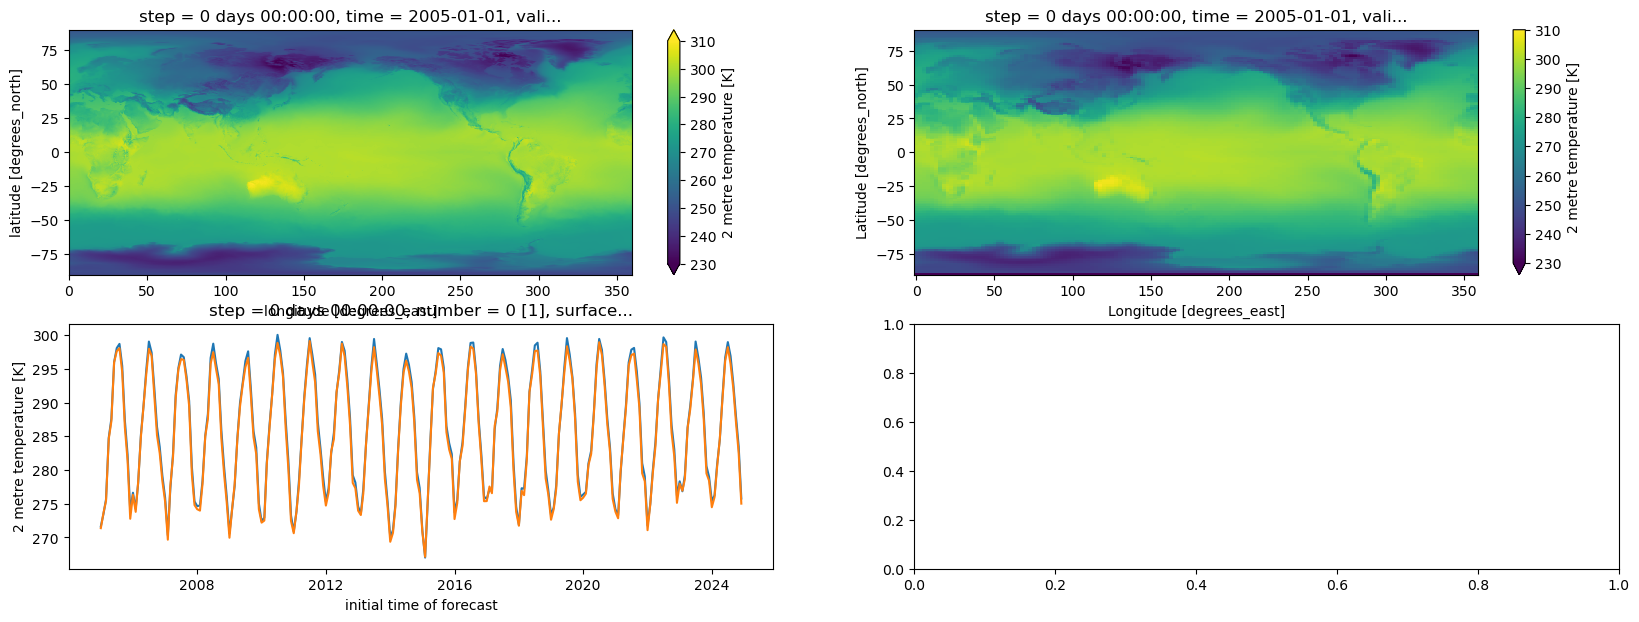

In [7]:
fig, ax = plt.subplots(2,2,figsize=(20,7))

# plot map for first time step
era5_tas_ds['tas'].isel(time=0).plot(ax=ax[0,0],vmin=230,vmax=310)
era5_tas_rg_ds['tas'].isel(time=0).plot(ax=ax[0,1],vmin=230,vmax=310)
# plot time series for roughly nyc
era5_tas_ds['tas'].sel(lat=40.7128,lon=285.994,method='nearest').plot(ax=ax[1,0])
era5_tas_rg_ds['tas'].sel(lat=40.7128,lon=285.994,method='nearest').plot(ax=ax[1,0])

In [8]:
hist_tas_rmse = xs.rmse(era5_tas_rg_ds.sel(time=slice('2005-01-01','2014-12-31'))['tas'],hist_ds['tas']).compute()
ssp_tas_rmse = xs.rmse(era5_tas_rg_ds.sel(time=slice('2015-01-01','2024-12-31'))['tas'],ssp_ds['tas']).compute()

In [9]:
print(f'historical simulation RMSE:   {hist_tas_rmse.values}')
print(f'SSP245 RMSE:                  {ssp_tas_rmse.values}')

historical simulation RMSE:   17.268756866455078
SSP245 RMSE:                  17.41364860534668


In [10]:
hist_tas_spat_rmse = xs.rmse(era5_tas_rg_ds.sel(time=slice('2005-01-01','2014-12-31'))['tas'],hist_ds['tas'],dim='time').compute()
ssp_tas_spat_rmse = xs.rmse(era5_tas_rg_ds.sel(time=slice('2015-01-01','2024-12-31'))['tas'],ssp_ds['tas'],dim='time').compute()

Text(0.5, 1.0, 'projection - historical')

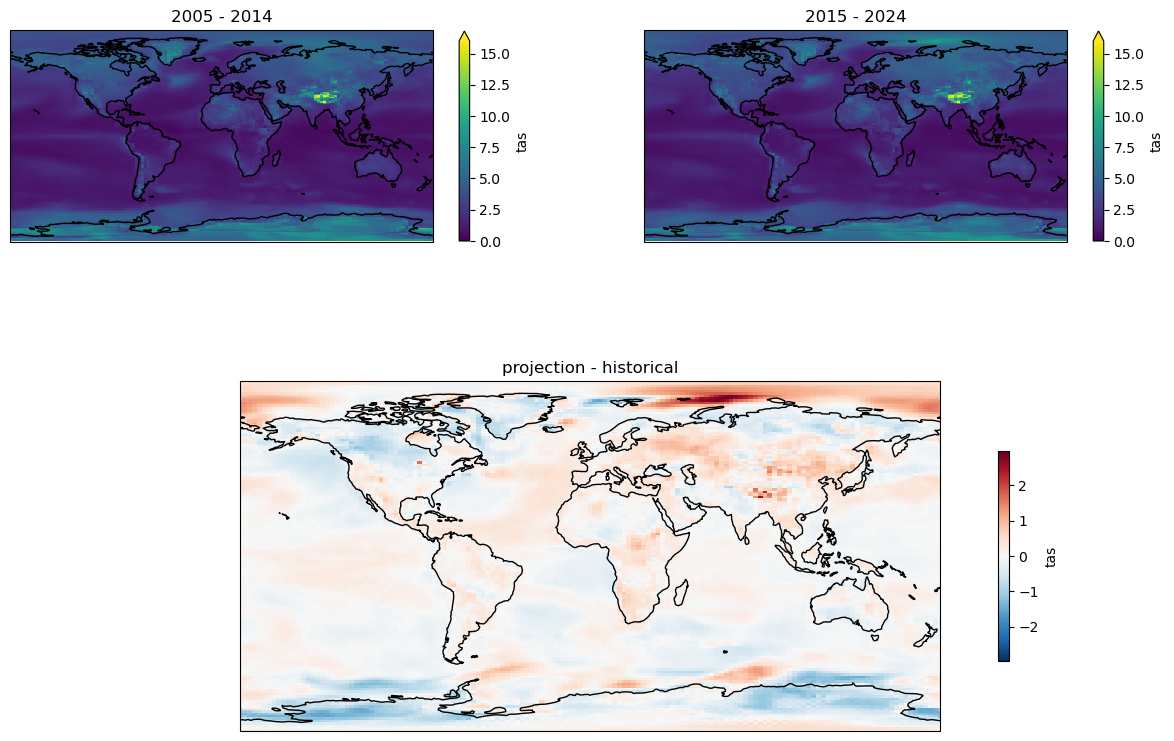

In [11]:
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)

proj = ccrs.PlateCarree()

ax1 = fig.add_subplot(gs[0, 0], projection=proj)
ax2 = fig.add_subplot(gs[0, 1], projection=proj)
ax3 = fig.add_subplot(gs[1, :], projection=proj)

# Add coastlines
for ax in [ax1, ax2, ax3]:
    ax.coastlines()
    ax.add_feature(cfeature.LAND, linewidth=0.5)
    ax.set_global()

# plot historical
hist_tas_spat_rmse.isel(lat=slice(1, -1)).plot(ax=ax1, vmin=0, vmax=16, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.6})
ax1.set_title('2005 - 2014')
# plot ssp245
ssp_tas_spat_rmse.isel(lat=slice(1, -1)).plot(ax=ax2, vmin=0, vmax=16, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.6})
ax2.set_title('2015 - 2024')
# plot difference in RMSE
(ssp_tas_spat_rmse - hist_tas_spat_rmse).isel(lat=slice(1, -1)).plot(ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.6})
ax3.set_title('projection - historical')